# Simulating outcomes from College Nationals 10,000 times

The goal is to evaluate which combination of 2 mens teams, 2 womens teams, and one 
bonus team (either division) will produce the most points, based on the following 
scoring system:


## Scoring:


- For each win in pool play and the bracket, you will receive points equal to the team’s seed within their pool.
- Winning your pool is worth one bonus point.
- Quarterfinal wins are worth one bonus point.
- Semifinal wins are worth two bonus points.
- Winning the championship is worth three bonus points.

Example: You select the Texas women, the third seed in Pool D. They go 2-2 in pool play, win their 
prequarter and quarterfinal, and lose in semifinals. They would earn 6 points for pool play (2 wins 
worth 3 points each), and 6 points for their two bracket wins (2 wins worth 3 points each), with one bonus point for winning a quarterfinal, totaling 13 points.

## Format:
20 teams in 4 pools of five teams:

### Womens Pools:
![title](WomensPools.png)

### Mens Pools:
![title](MensPools.png)

### Bracket:
![title](WomensBracket.png)



Daniel Walton 5/16/2019

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import re
import math
import collections
from numpy.random import binomial
%matplotlib inline

In [2]:
# Low res figures for now
%matplotlib inline

In [12]:
# Get some good colors for plotting
cmap = cm.get_cmap('Set1')
num_colors = 9
colors = {}
for i in range(num_colors):
    colors[i] = cmap((i+0.5)/num_colors)

In [3]:
# Handy way for storing scores
Score = collections.namedtuple('Score', ['team_a', 'team_b'])

In [4]:
# Format for game logs
GameLog = collections.namedtuple('GameLog', ['level','name','team_a_name','team_b_name','score','winner','loser',\
                                             'child_a','child_b','parent'])

In [5]:
# Test for GameLog type
log_semis = GameLog(level='S', name='Semis1', team_a_name='North Carolina', team_b_name='Washington', \
                    score=Score(team_a=15, team_b=12), winner='North Carolina', loser='Washington', \
                   child_a=None, child_b=None, parent=None)
print(log_semis)
print(type(log_semis))

GameLog(level='S', name='Semis1', team_a_name='North Carolina', team_b_name='Washington', score=Score(team_a=15, team_b=12), winner='North Carolina', loser='Washington', child_a=None, child_b=None, parent=None)
<class '__main__.GameLog'>


In [462]:
# Abbreviation for Rounds('levels')
level_dict = {'PP':'Pool Play', 'P':'Prequarter', 'Q':'Quarter', 'S':'Semifinal', 'F':'Final', 'W':'Winner'}

In [506]:
# Scoring for 'TheGame'
get_pool_play_points = lambda seed, pool_play_wins, rank: seed*pool_play_wins + int(rank==1) 

bracket_bonus = {'PP':0, 'P':0, 'Q':1, 'S':2, 'F':3, 'W':0} # Champion has no-one left to bead
accumulated_bracket_bonus = {'PP':0, 'P':0, 'Q':1, 'S':3, 'F':6, 'W':6} # cumulative sum of bracket_bonus

get_bracket_play_points = lambda seed, bracket_play_wins, highest_game_won: seed*bracket_play_wins + \
                                                                       accumulated_bracket_bonus[highest_game_won]

get_total_points = lambda seed, pool_play_wins, rank, bracket_play_wins, highest_game_won: \
                    get_pool_play_points(seed, pool_play_wins, rank) + \
                    get_bracket_play_points(seed, bracket_play_wins, highest_game_won)

In [466]:
# Testing scoring
get_total_points(5,0,5,0,'PP')

0

In [13]:
# Get USAU Ratings
#
# Read in FullTeamRankings saved from USAU Ultimate Rankings Page 5/16/2019
# link: https://play.usaultimate.org/teams/events/team_rankings/?RankSet=College-Women
#
# Couldn't get all teams directly, so just clicked show all and then saved as .html locally.

womens_ranking_html = r'FullTeamRankings_women.html'
mens_ranking_html   = r'FullTeamRankings_men.html'

# Use pandas html reader to extract dataframe
result = pd.read_html(womens_ranking_html)
df_women = result[0]

result = pd.read_html(mens_ranking_html)
df_men = result[0]

# Last row contains garbage, so remove it.
df_women = df_women.drop(index=len(df_women)-1)
df_men   = df_men.drop(index=len(df_men)-1)

# Convert numeric columns to from string/object to correct type
cols = ['Rank', 'Power Rating', 'Wins', 'Losses']
df_women[cols] = df_women[cols].apply(pd.to_numeric)
df_men[cols] = df_men[cols].apply(pd.to_numeric)

In [17]:
# Get Nationals pools
#
# womens url = r'http://collegechampionships.usaultimate.org/d1-women/schedule-results/'
# mens url   = r'http://collegechampionships.usaultimate.org/d1-men/schedule-results/' 
#
def get_pools(pools_dict):
    """
    Determine the pools based on a pools dictionary that looks like this:
    
    {'A':'North Carolina (1) Ohio State (8) Georgia (12) Minnesota (13) California (17)',
     'B':'Brown (2) North Carolina State (7) Texas (11) Michigan (14) Iowa State (18)',
     'C':'Pittsburgh (3) Oregon (6) Wisconsin (10) Tufts (15) Victoria (19)',
     'D':'Cal Poly-SLO (4) Colorado (5) Washington (9) Northeastern (16) Rutgers (20)'}
    
    Returns a dictionary with the same keys, but the values are now tuples with the team names (no seeds) in order.
    """
    
    for pool, string in pools_dict.items():
        # Initial Split
        string_split = re.split(' \([0-9]+\)', string) 

        # Clean up leading spaces and final entry
        del string_split[-1]
        string_split = [item[1:] if item[0]==' ' else item for i, item in enumerate(string_split)]

        # Create tuple
        pools_dict[pool] = tuple(string_split)
    return pools_dict


# Get women's and men's pools
womens_pools = get_pools({'A':'North Carolina (1) Pittsburgh (8) UCLA (12) Colorado (13) Oregon (17)',
                 'B':'Ohio State (2) California-Santa Barbara (7) Northeastern (11) Minnesota (14) Washington (18)',
                 'C':'California-San Diego (3) Western Washington (6) Georgia (10) Tufts (15) Northwestern (19)',
                 'D':'Carleton College-Syzygy (4) Dartmouth (5) Texas (9) Wisconsin (16) Cornell (20)'})

mens_pools = get_pools({'A':'North Carolina (1) Ohio State (8) Georgia (12) Minnesota (13) California (17)',
                 'B':'Brown (2) North Carolina State (7) Texas (11) Michigan (14) Iowa State (18)',
                 'C':'Pittsburgh (3) Oregon (6) Wisconsin (10) Tufts (15) Victoria (19)',
                 'D':'Cal Poly-SLO (4) Colorado (5) Washington (9) Northeastern (16) Rutgers (20)'})

# Get number of teams per pool
teams_per_pool = len(womens_pools['A'])
print('# teams per pool: '+str(teams_per_pool)+'\n')

# Print pools
print(womens_pools)
print('\n',mens_pools)

# teams per pool: 5

{'A': ('North Carolina', 'Pittsburgh', 'UCLA', 'Colorado', 'Oregon'), 'B': ('Ohio State', 'California-Santa Barbara', 'Northeastern', 'Minnesota', 'Washington'), 'C': ('California-San Diego', 'Western Washington', 'Georgia', 'Tufts', 'Northwestern'), 'D': ('Carleton College-Syzygy', 'Dartmouth', 'Texas', 'Wisconsin', 'Cornell')}

 {'A': ('North Carolina', 'Ohio State', 'Georgia', 'Minnesota', 'California'), 'B': ('Brown', 'North Carolina State', 'Texas', 'Michigan', 'Iowa State'), 'C': ('Pittsburgh', 'Oregon', 'Wisconsin', 'Tufts', 'Victoria'), 'D': ('Cal Poly-SLO', 'Colorado', 'Washington', 'Northeastern', 'Rutgers')}


In [18]:
def get_list_teams_from_pools(pools):
    """
    Lists all teams in the tournament.
    
    Takes a pools dict (must be format {'A': ('Name1', ..., 'NameN'), ..., 'C':('Name1',...,'NameN')})
    and unpacks it into a list of teams.
    
    Returns list of teams in that division.
    """
    
    teams = []
    for key, item in pools.items():
        teams.extend(list(item))
        
    return teams

In [22]:
# Get lists of teams at Nationals in women's and men's division
womens_teams = get_list_teams_from_pools(womens_pools)
mens_teams = get_list_teams_from_pools(mens_pools)

print('Women\'s Teams: ')
print(womens_teams)
print('\nMen\'s Teams: ')
print(mens_teams)

Women's Teams: 
['North Carolina', 'Pittsburgh', 'UCLA', 'Colorado', 'Oregon', 'Ohio State', 'California-Santa Barbara', 'Northeastern', 'Minnesota', 'Washington', 'California-San Diego', 'Western Washington', 'Georgia', 'Tufts', 'Northwestern', 'Carleton College-Syzygy', 'Dartmouth', 'Texas', 'Wisconsin', 'Cornell']

Men's Teams: 
['North Carolina', 'Ohio State', 'Georgia', 'Minnesota', 'California', 'Brown', 'North Carolina State', 'Texas', 'Michigan', 'Iowa State', 'Pittsburgh', 'Oregon', 'Wisconsin', 'Tufts', 'Victoria', 'Cal Poly-SLO', 'Colorado', 'Washington', 'Northeastern', 'Rutgers']


In [23]:
# Give each team a color
womens_colors = ['skyblue', 'darkkhaki', 'cornflowerblue', 'gold', \
                 'darkgreen', 'silver', 'darkorange', 'crimson', 'black', \
                 'mediumpurple', 'midnightblue', 'dimgray', 'red', \
                 'darkblue', 'deepskyblue', 'rebeccapurple', 'seagreen',\
                 'chocolate', 'limegreen', 'salmon']

mens_colors = ['black', 'silver', 'red', 'dimgray', 'navy', 'sienna', 'maroon', \
               'orange', 'mediumblue', 'lightcoral', 'darkkhaki', 'green', \
               'lightskyblue', 'deepskyblue', 'royalblue', 'lime', \
               'gold', 'rebeccapurple', 'black', 'crimson']

womens_team_colors = dict(zip(womens_teams, womens_colors))
mens_team_colors = dict(zip(mens_teams, mens_colors))

In [24]:
def get_df_of_team_power_ratings(teams, df_full):
    """
    Gets a dataframe with ratings of nationals teams.
    
    Takes as input the desired teams and a data frame with the full set of ratings of all teams in the
    division, then extracts the ratings for the list of teams considered.
    
    Returns a data frame with Power Rating of desired teams.
    """
    
    # Deal with Carleton College-Syzygy vs Carleton College
    if 'Carleton College' in teams:
        teams.append('Carleton College-Syzygy')
        teams.remove('Carleton College')
    
    return df_full.loc[df_full['Team'].isin(teams)][['Team','Power Rating']].set_index('Team')

In [25]:
# Get ratings of men's and women's nationals-bound teams
womens_team_ratings = get_df_of_team_power_ratings(womens_teams, df_women)
mens_team_ratings   = get_df_of_team_power_ratings(mens_teams, df_men)

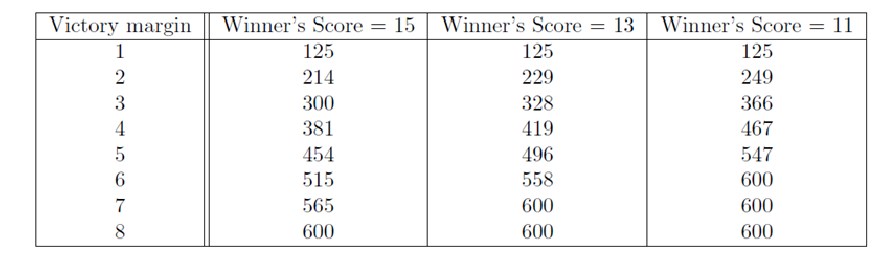

In [26]:
# Table that translates score differential to victory margin
image = plt.imread('RankingAlgorithmTable.png')
plt.figure(figsize=(15,5))
plt.imshow(image)
plt.axis('off');

In [27]:
def get_poly_function_rating_diff_to_victory_margin(rating_diff, victory_margin, game_to=15, poly_degree=3):
    """ 
    Create function to convert from points diff to victory margin.
    
    Takes as input an array of rating_diff and victory_margin.  Then fits a poly_dgree degree polynomial.
    
    Returns a function applies the polynomial but caps the victory margin at game_to.  (Because, you can't 
    win by 20 if the game is to 15, no matter how much better you are.)
    """
    
    # Fit a third degree polynomial
    coefs = np.polyfit(rating_diff, victory_margin, poly_degree)
    poly = np.poly1d(coefs)

    # Cap margin between 0 and game_to
    poly_with_cap = lambda x: np.maximum(np.minimum(poly(x), game_to),0) 
    
    return poly_with_cap

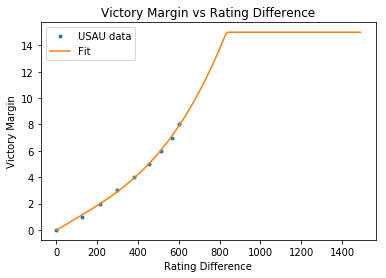

In [28]:
# Test for rating_diff_to_victory_margin

# Start with USAU algorithm data 
# (Assume winner gets 15 points)
victory_margin = np.array([0, 1,   2,   3,   4,   5,   6,   7,   8])
rating_diff =    np.array([0, 125, 214, 300, 381, 454, 515, 565, 600])

game_to = 15

# Fit function
rating_diff_to_victory_margin = get_poly_function_rating_diff_to_victory_margin(rating_diff, victory_margin, \
                                                                                game_to=game_to)

# Plot results
rating_diff_full = np.arange(0,1500,10)

plt.figure()
plt.plot(rating_diff, victory_margin, linestyle='none', marker = '.', label='USAU data')
plt.plot(rating_diff_full, rating_diff_to_victory_margin(rating_diff_full), label='Fit')
plt.xlabel('Rating Difference')
plt.ylabel('Victory Margin')
plt.title('Victory Margin vs Rating Difference')
plt.legend()
plt.show()

In [29]:
def convert_ratings_to_expected_game_score(team_a_rating, team_b_rating, game_to):
    """
    Take USAU Power Ratings of two teams and get expected game_score
    """
    if team_a_rating >= team_b_rating:
        team_a_score = game_to
        team_b_score = team_a_score - rating_diff_to_victory_margin(team_a_rating-team_b_rating)
    else:
        team_b_score = game_to
        team_a_score = team_b_score - rating_diff_to_victory_margin(team_b_rating-team_a_rating)
    score = Score(team_a=team_a_score, team_b=team_b_score)
    return score

In [30]:
def simulate_binomial_game(game_to, p):
    """
    Simulate a binomial game to game_to with a probability of success p.
    
    Game ends when either team's score reaches game_to.
    
    Returns a Score tuple of the scores.
    """
    
    team_a_score, team_b_score = 0, 0
    
    game_is_going = True
    
    while game_is_going:
        if np.random.rand() < p:
            team_a_score += 1
        else:
            team_b_score += 1
        game_is_going = (team_a_score < game_to) and (team_b_score < game_to)
    
    return Score(team_a=team_a_score, team_b=team_b_score)

In [31]:
def simulate_double_negative_binomial_game(game_to, p_a_offense, p_b_offense):
    """
    Simulate a game by flipping a coin with p_heads = p_a_offense until heads (heads->Team A, tails->Team B).
    Then, flip a coin with p_heads = p_b_offense until heads (heads->Team B, tails->Team A).
    
    Game ends when either team's score reaches game_to.
    
    Returns a Score tuple of the scores.
    """
    
    # Determine starting team
    team_a_on_offense = np.random.rand() < 0.5
    
    # Game starts 0-0
    team_a_score, team_b_score = 0, 0
    
    # Start game
    game_is_going = True
    
    
    while game_is_going:
        if team_a_on_offense:
            if np.random.rand() < p_a_offense:
                team_a_score += 1
                team_a_on_offense = False
            else:
                team_b_score += 1
        else:
            if np.random.rand() < p_b_offense:
                team_b_score += 1
                team_a_on_offense = True
            else:
                team_a_score += 1
        game_is_going = (team_a_score < game_to) and (team_b_score < game_to)
    return Score(team_a=team_a_score, team_b=team_b_score)

In [32]:
# Test for double negative binomial process

P_WINNER_SCORE_TEST = 0.8
GAME_TO_TEST = 15
RANDOM_SEED_TEST = 42
NUM_GAMES_TEST = 20
SCORE1_TEST = 15
SCORE2_TEST = 10

np.random.seed(RANDOM_SEED_TEST)
team_a_expected_score = SCORE1_TEST
team_b_expected_score = SCORE2_TEST
print(f'Expected {team_a_expected_score}-{team_b_expected_score}')
for _ in range(NUM_GAMES_TEST):
    print(simulate_double_negative_binomial_game(GAME_TO_TEST, P_WINNER_SCORE_TEST, \
                                                 P_WINNER_SCORE_TEST*(team_b_expected_score/team_a_expected_score)))

np.random.seed(RANDOM_SEED_TEST )
team_a_expected_score = SCORE2_TEST
team_b_expected_score = SCORE1_TEST
print(f'\nExpected {team_a_expected_score}-{team_b_expected_score}')
for _ in range(NUM_GAMES_TEST):
    print(simulate_double_negative_binomial_game(GAME_TO_TEST, \
                                                 P_WINNER_SCORE_TEST*(team_a_expected_score/team_b_expected_score), \
                                                 P_WINNER_SCORE_TEST))

Expected 15-10
Score(team_a=15, team_b=13)
Score(team_a=15, team_b=8)
Score(team_a=15, team_b=7)
Score(team_a=15, team_b=9)
Score(team_a=15, team_b=7)
Score(team_a=15, team_b=12)
Score(team_a=15, team_b=9)
Score(team_a=15, team_b=8)
Score(team_a=15, team_b=4)
Score(team_a=15, team_b=13)
Score(team_a=15, team_b=4)
Score(team_a=15, team_b=6)
Score(team_a=15, team_b=8)
Score(team_a=15, team_b=8)
Score(team_a=15, team_b=9)
Score(team_a=15, team_b=9)
Score(team_a=12, team_b=15)
Score(team_a=15, team_b=10)
Score(team_a=15, team_b=7)
Score(team_a=15, team_b=9)

Expected 10-15
Score(team_a=12, team_b=15)
Score(team_a=8, team_b=15)
Score(team_a=8, team_b=15)
Score(team_a=5, team_b=15)
Score(team_a=8, team_b=15)
Score(team_a=15, team_b=11)
Score(team_a=11, team_b=15)
Score(team_a=9, team_b=15)
Score(team_a=6, team_b=15)
Score(team_a=12, team_b=15)
Score(team_a=6, team_b=15)
Score(team_a=9, team_b=15)
Score(team_a=7, team_b=15)
Score(team_a=10, team_b=15)
Score(team_a=12, team_b=15)
Score(team_a=

In [33]:
def simulate_game_outcome(team_a_rating, team_b_rating, method='double negative binomial', game_to=15, \
                          p_winner_offense=0.8):
    """
    Simulate the outcome of single game played between team A and team B. 
    The result should be based on the teams' ratings.
    
    This function returns True if team A wins and False if team B wins, and the score.
    
    """
    
    # Team A always wins
    if method=='team_a': 
        team_a_score = game_to
        team_b_score = np.max([0,team_a_score-2])
    
    # Team B always wins
    elif method=='team_b': # Team A wins
        team_b_score = game_to
        team_a_score = np.max([0,team_b_score-2])
    
    # Higher rating always wins
    elif method=='higher_rating': # Team A wins
        if team_a_rating > team_b_rating:
            team_a_score = game_to
            team_b_score = np.max([0,team_a_score-2])
        else:
            team_a_score = game_to
            team_b_score = np.max([0,team_a_score-2])
    
    # Random coin flip
    elif method=='random': 
        if random.random()>0.5:
            team_a_score = game_to
            team_b_score = np.max([0,team_a_score-2])
        else:
            team_a_score = game_to
            team_b_score = np.max([0,team_a_score-2])
    
    # 'binomial': Simulate game as first to achieve 15 successes of a weighted coin flip.
    #
    # Assume if game is expected to finish Team A 15-8 Team B, then the probability of Team A
    # winning a particular point is p = 15 / (15 + 8).
    # Then, a new full game can be simulated as a sequence of Bernoulli trials with probability with p
    # that terminates when either the number of success or failures reaches game_to.
    elif method=='binomial': # Use ratings
        expected_score = convert_ratings_to_expected_game_score(team_a_rating, team_b_rating, game_to)
        
        p = expected_score.team_a*1.0 / (expected_score.team_a + expected_score.team_b) # Prob A wins a given point
        
        actual_score_this_time = simulate_binomial_game(game_to, p)
        team_a_score = actual_score_this_time.team_a
        team_b_score = actual_score_this_time.team_b
        
    
    
#     'double negative binomial': Simulate game as using two weighted coins (one for each team's offense).  
    
#     Randomly decide which team starts on offense.  Say team A goes first, flip their weighted coin with 
#     probability P_a_offense until a heads is seen.  Record 1 point for Team A and the number of tails seen
#     as points for Team B.  Then it's B's turn to be on offense.  Flip the weighted coin with probability P_b_offense
#     until a heads seen.  Record a 1 point from Team B and the number of tails seen as points for Team A.
#     Repeat until one team has 15 points.
    
#     Assumes there are two distinct fixed probabilities: 
#      -  P_a_offense = the prob A scores a point when on offense
#      -  P_b_offense = the prob B score a point when on offense
    
#     We don't know a priori what the relationship is between P_a_offense and P_b_offense.  And we only have one
#     input currently: the expected game score (e.g. 15-8).  So we have two unknowns and one piece of information.
#     So, we make the simplifying assumption (based on data from Ultianalytics.com) that for elite mens college 
#     teams, the winning team typically has a P_a_offense = 0.8.  Then, to get an expected result 15-8, we need
#     P_b_offense = P_a_offense * 8/15. 
    
#     Note: P_a_offense = 0.8 is an important assumption.  If it were greater, scores would have less variance.
#     If it were less, scores would have more variance.  Thus, if it's a cross wind, then P_a_offense would likely be 
#     closer to 0.5.  Meanwhile, in perfect conditions, one would expect P_a_offense to be slightly higher.
    
    elif method=='double negative binomial': 
        # Convert ratings to expected score
        expected_score = convert_ratings_to_expected_game_score(team_a_rating, team_b_rating, game_to)
        
        # Assign expected winner's probability of scoring an O-point to be p_winner_offense (usually 0.8)
        if expected_score.team_a > expected_score.team_b:
            p_a_offense = p_winner_offense
            p_b_offense = p_a_offense * expected_score.team_b/(1.0*game_to)
        else:
            p_b_offense = p_winner_offense
            p_a_offense = p_b_offense * expected_score.team_a/(1.0*game_to)

        # Simulate double binomial
        actual_score_this_time = simulate_double_negative_binomial_game(game_to, p_a_offense=p_a_offense, \
                                                                        p_b_offense=p_b_offense)
        team_a_score = actual_score_this_time.team_a
        team_b_score = actual_score_this_time.team_b
        
    
    # Method not recognized
    else:
        raise ValueError('method not recognized')
        team_a_score = -1
        team_b_score = -2
    
    # Record score in named Tuple
    score = Score(team_a=team_a_score, team_b=team_b_score)
    
    # Team A wins if they have more points
    team_a_wins = score.team_a > score.team_b
    
    return team_a_wins, score

In [34]:
# Test simulate_game_outcome
np.random.seed(42)
num_games_test = 10000

method = 'double negative binomial'
game_to = 15

team_a = 'North Carolina'

team_a_rating = mens_team_ratings.loc[team_a]['Power Rating']
rating_diff_values = np.arange(0,1000,10)
team_a_win_perc = np.zeros(rating_diff_values.shape)

team_a_score_counters = collections.defaultdict(collections.Counter)
team_b_score_counters = collections.defaultdict(collections.Counter)

for i, rating_diff in enumerate(rating_diff_values):
    team_b_rating = team_a_rating - rating_diff
    
    num_team_a_wins = 0
    num_team_b_wins = 0
    
    for _ in range(num_games_test):
        team_a_wins, score = simulate_game_outcome(team_a_rating, team_b_rating, method=method, game_to=game_to)
        
        # Tally wins
        if team_a_wins:
            num_team_a_wins += 1 
        else: 
            num_team_b_wins += 1 
    
        team_a_score_counters[rating_diff][score.team_a] += 1
        team_b_score_counters[rating_diff][score.team_b] += 1
    
    team_a_win_percentage_here = num_team_a_wins/num_games_test
    team_a_win_perc[i] = team_a_win_percentage_here

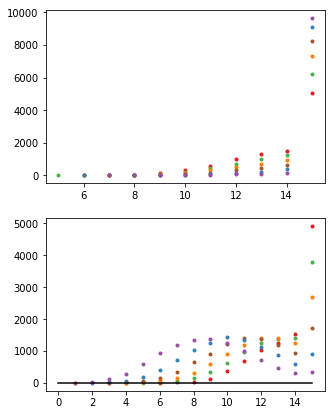

In [39]:
# Plot distributions
plt.figure(figsize=(5,7))
plt.subplot(2,1,1)
for diff in range(0,600,100):
    for team_a_score, count in team_a_score_counters[diff].items():
        plt.plot(team_a_score, count, '.', color=colors[int(np.mod(diff,7))])
plt.subplot(2,1,2)
for diff in range(0,600,100):
    for team_b_score, count in team_b_score_counters[diff].items():
        plt.plot(team_b_score, count, '.', color=colors[int(np.mod(diff,7))])
plt.plot([0, 15], [0, 0], 'k')
#plt.ylim([0, num_games_test])
plt.show()

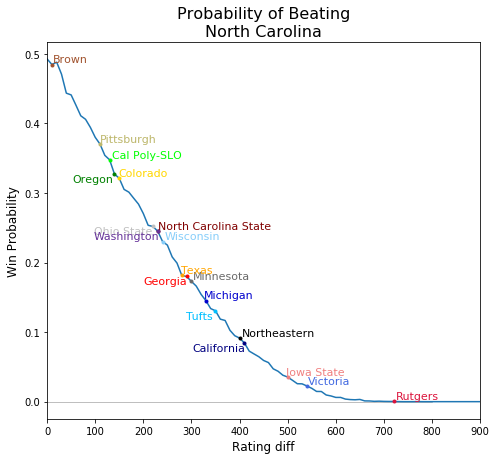

In [288]:
# North Carolina Test Case
division = 'Men\'s'
fig = plt.figure(figsize=(7, 6.5))
fig.patch.set_facecolor('white')
plt.plot([0, 800], [0, 0], color='gray', linestyle='-', linewidth=0.5)
plt.plot(rating_diff_values, 1-team_a_win_perc)
flip_teams = ['Washington','California', 'Oregon', 'Georgia', 'Tufts', 'Ohio State']
ignore_teams = [team_a]
for team in mens_teams:
    if team not in ignore_teams:
        team_rating_here = mens_team_ratings.loc[team]['Power Rating']
        index_min_rating_diff = np.argmin(abs(rating_diff_values-(team_a_rating-team_rating_here)))
        team_a_win_perc_here = team_a_win_perc[index_min_rating_diff]
        #plt.plot([team_a_rating - team_rating_here, team_a_rating - team_rating_here], [0.0, 1.0], color=mens_team_colors[team])
        plt.plot(rating_diff_values[index_min_rating_diff], 1-team_a_win_perc_here, color=mens_team_colors[team], \
                 linestyle='none', marker='.')
        text_here = team + ' (self)' if team==team_a else team
        FONTSIZE = 11
        if team in flip_teams:
            plt.text(team_a_rating-team_rating_here, 1-team_a_win_perc_here, text_here, color=mens_team_colors[team], \
                     rotation=-0, verticalalignment='top', horizontalalignment='right',fontsize=FONTSIZE)
        else:
            plt.text(team_a_rating-team_rating_here, 1-team_a_win_perc_here, text_here, color=mens_team_colors[team], \
                     rotation=-0, verticalalignment='bottom', horizontalalignment='left',fontsize=FONTSIZE)
#plt.ylim([0.0, 1.0])
plt.xlim([-0, 900])
#plt.yticks(np.arange(0.0,1.2,.2))
plt.ylabel(f'Win Probability', fontsize = 12)
plt.xlabel(f'Rating diff', fontsize = 12)
#plt.title(f'Probabilty of Beating\n{team_a}\n(n = {num_games_test})', fontsize = 16)
plt.title(f'Probability of Beating\n{team_a}', fontsize = 16)
plt.tight_layout()
plt.show()

In [514]:
# Game class - used for simulating bracket game
class Game:
    def __init__(self, level=None, name='', team_a_name=None, team_b_name=None, \
                 parent=None, child_a=None, child_b=None, \
                 team_a_score=0, team_b_score=0, winner_name=None, winner_rating=None, \
                 loser_name=None, loser_rating=None, played=False, \
                 team_a_rating=None, team_b_rating=None, game_to=15, \
                 log=None, method='double negative binomial'):
        self.level=level
        self.name = name
        self.parent = parent
        self.played = False
        self.team_a_name = team_a_name
        self.team_b_name = team_b_name
        self.parent = parent
        self.child_a = child_a
        self.child_b = child_b
        self.team_a_score = team_a_score
        self.team_b_score = team_b_score
        self.winner_name = winner_name
        self.winner_rating = winner_rating
        self.loser_name = loser_name
        self.loser_rating = loser_rating
        self.team_a_rating = team_a_rating
        self.team_b_rating = team_b_rating
        self.game_to = game_to
        self.method = method
        self.score = None
        self.team_a_wins = None
        self.log = log
        
    def set_team_a_wins():
        if self.played:
            return self.team_a_score > self.team_b_score
        else:
            raise Exception('Game has not been played!')
    
    def set_winner(self):
        if self.played:
            if self.team_a_wins:
                self.winner_name = self.team_a_name
                self.winner_rating = self.team_a_rating
                self.loser_name = self.team_b_name
                self.loser_rating = self.team_b_rating
                self.winner_score = self.team_a_score
                self.loser_score = self.team_b_score
            else:
                self.winner_name = self.team_b_name
                self.winner_rating = self.team_b_rating
                self.loser_name = self.team_a_name
                self.loser_rating = self.team_a_rating
                self.winner_score = self.team_b_score
                self.loser_score = self.team_a_score
        else:
            raise Exception('Games has not been played!')
    
    def play_game(self):
        if self.played:
            raise Exception('Game already played!')
        if self.team_a_rating and self.team_b_rating:
            self.team_a_wins, score = simulate_game_outcome(self.team_a_rating, self.team_b_rating, \
                                                            method=self.method, game_to=self.game_to)
            self.score = score
            self.team_a_score, self.team_b_score = score.team_a, score.team_b
            self.played = True
            self.set_winner()
        else:
            raise Exception('Need team_a_rating and team_b_rating to be not None!')
    
    def log_score(self):
        game = GameLog(level=self.level, name=self.name, \
                team_a_name=self.team_a_name, team_b_name=self.team_b_name, \
                score=self.score, winner=self.winner_name, loser=self.loser_name, \
                child_a=(self.child_a.name if self.child_a else None), \
                child_b=(self.child_b.name if self.child_b else None), \
                parent=(self.parent.name if self.parent else None))
        try:
            self.log.append(game)
        except:
            self.log = [game]
    
    def extend_log(self, other_log):
        try:
            self.log.extend(other_log)
        except:
            self.log = other_log
    
    def play_children_and_self(self):
        if self.child_a:
            self.child_a.parent = self
            if not self.child_a.played:
                self.child_a.play_children_and_self()
            self.team_a_name = self.child_a.winner_name
            self.team_a_rating = self.child_a.winner_rating
            self.extend_log(self.child_a.log)
        if self.child_b:
            self.child_b.parent = self
            if not self.child_b.played:
                self.child_b.play_children_and_self()
            self.team_b_name = self.child_b.winner_name
            self.team_b_rating = self.child_b.winner_rating
            self.extend_log(self.child_b.log)
        if not self.played:
            self.play_game()
            self.log_score()
            #print(self.name + ': ' + self.winner_name + ' beats ' + self.loser_name+f' {self.winner_score}-{self.loser_score}!')

In [515]:
# Tests for Game class
quarterfinal = Game(level='Q', name='Quarterfinal 1', team_a_name='Colorado', team_a_rating=1800)
quarterfinal.team_b_name, quarterfinal.team_b_rating = 'Washington', 1750
print(quarterfinal.team_b_rating)

semifinal = Game(level='S', name='Semifinal 1', team_a_name='North Carolina', team_a_rating=2100, child_b=quarterfinal)
print(semifinal.team_a_rating)
print(semifinal.played)

np.random.seed(37)
semifinal.play_children_and_self()

print('Quarterfinal:')
print(quarterfinal.score)
print(quarterfinal.winner_name)
print(quarterfinal.team_a_score)
print(quarterfinal.team_b_score)
print(quarterfinal.played)
print(quarterfinal.team_a_wins)
print('\nSemifinal:')
print(semifinal.team_a_name)
print(semifinal.team_b_name)
print(semifinal.team_a_score)
print(semifinal.team_b_score)
print(semifinal.score)
print(semifinal.winner_name)
print(semifinal.played)
print(semifinal.team_a_wins)
print('')
print('Log:')
print(semifinal.log)

1750
2100
False
Quarterfinal:
Score(team_a=15, team_b=10)
Colorado
15
10
True
True

Semifinal:
North Carolina
Colorado
12
15
Score(team_a=12, team_b=15)
Colorado
True
False

Log:
[GameLog(level='Q', name='Quarterfinal 1', team_a_name='Colorado', team_b_name='Washington', score=Score(team_a=15, team_b=10), winner='Colorado', loser='Washington', child_a=None, child_b=None, parent='Semifinal 1'), GameLog(level='S', name='Semifinal 1', team_a_name='North Carolina', team_b_name='Colorado', score=Score(team_a=12, team_b=15), winner='Colorado', loser='North Carolina', child_a=None, child_b='Quarterfinal 1', parent=None)]


In [534]:
def simulate_pool_play(pools, ratings, max_rank_make_bracket=3):
    """
    
    Simulate Pool Play
    
    Here are the rules for breaking ties:
    http://www.usaultimate.org/assets/1/AssetManager/Format%20Manual%20Version%204.3%20_7.1.08__updated%208.25.10_.pdf
    
    
    """
    
    win_loss_matrix_list = [] # record wins
    score_matrix_list = [] # record scores
    
    pool_play_outcomes_dict = {} # record pool play outcomes
    
    # Play all games
    for pool, teams in pools.items():
        num_teams = len(teams)
        teams_list = list(teams)
        team_wins = collections.defaultdict(int)
        team_index = {team:i for i,team in enumerate(teams_list)}
        team_rvindex = {i:team for i,team in enumerate(teams_list)}
        
        win_loss_matrix = np.zeros([num_teams,num_teams]) # For recording wins
        score_matrix = np.zeros([num_teams,num_teams]) # For recording scores
        
        max_loops = 10
        loops = 0
        while teams_list and loops < max_loops:
            team_A = teams_list.pop()
            
            for team_B in teams_list:
                
                # Simulate the game
                team_a_wins, score = simulate_game_outcome(ratings.loc[team_A].values[0], \
                                                           ratings.loc[team_B].values[0], method='double negative binomial')
                #print(team_A, ratings.loc[team_A].values[0], team_B, ratings.loc[team_B].values[0], team_a_wins)
                
                # Log the wins
                win_loss_matrix[team_index[team_A],team_index[team_B]] = int(team_a_wins)
                win_loss_matrix[team_index[team_B],team_index[team_A]] = int(not team_a_wins)
                
                # Log the score
                score_matrix[team_index[team_A],team_index[team_B]] = score.team_a
                score_matrix[team_index[team_B],team_index[team_A]] = score.team_b
                
            loops += 1
        
        win_loss_matrix_list.append(win_loss_matrix)
        score_matrix_list.append(score_matrix)
    
        # Create data frame to store pool play outcomes
        pool_play_outcomes = pd.DataFrame(list(teams), columns=['Team'])
    
        # Count Wins and Losses
        wins   = [sum(win_loss_matrix[team_index[team],:]) for team in teams]
        losses = [num_teams-1-num for num in wins]
        pool_play_outcomes['Wins'] = wins
        pool_play_outcomes['Losses'] = losses
        
        # Determine Pool Finish (Rank)
        """
        WARNING: ACTUAL USAU TIE BREAKER RULES ARE NOT USED
        """
        pool_play_outcomes.sort_values(by='Wins', inplace=True, ascending=False)
        pool_play_outcomes.reset_index(inplace=True)
        pool_play_outcomes.rename(columns = {'index':'Seed'}, inplace=True) 
        
        # Get Rank and Seed 
        # (where did each team start and where did the finish in 1-based indexing)
        pool_play_outcomes['Rank'] = list(pool_play_outcomes.index.values + 1)
        pool_play_outcomes['Seed'] = pool_play_outcomes['Seed'] + 1

        # Made bracket?
        pool_play_outcomes['MadeBracket'] = pool_play_outcomes['Rank'].apply(lambda r : r <= max_rank_make_bracket)
        
        # Calculate points earned
        pool_play_outcomes['Points'] = pool_play_outcomes['Seed'] * pool_play_outcomes['Wins'] + \
                                       (pool_play_outcomes['Rank']==1).astype(int)
    
        # Add Pool to columns
        pool_play_outcomes['Pool'] = [pool]*len(pool_play_outcomes.index)
        
        # Differentiate pool play data from total data
        pool_play_outcomes['PoolPlayPoints'] = pool_play_outcomes['Points']
        pool_play_outcomes['PoolPlayWins'] = pool_play_outcomes['Wins']
        pool_play_outcomes['PoolPlayLosses'] = pool_play_outcomes['Losses']
        
        # Record highest level achieved as pool play -- for now
        pool_play_outcomes['HighLevel'] = ['PP']*len(pool_play_outcomes.index)
        
        # Reorder columns
        pool_play_outcomes = pool_play_outcomes[['Pool','Rank','Seed', 'Team', \
                                                 'PoolPlayPoints', 'PoolPlayWins', 'PoolPlayLosses',\
                                                 'Wins', 'Losses','Points', 'MadeBracket', 'HighLevel']]
    
        # Record these outcomes
        pool_play_outcomes_dict[pool] = pool_play_outcomes
    
    
    # Keep track of points earned
    return pool_play_outcomes_dict

In [535]:
def simulate_bracket_play(pool_play_results, ratings, bracket_format='12-team pool winners bye'):
    
    # Gather pool play results from each pool into single dataframe
    for pool, pool_results in pool_play_results.items():
            if pool=='A':
                tournament_results = pool_results
            else:
                tournament_results = tournament_results.append(pool_results)
    
    # Reset index
    tournament_results.reset_index(inplace=True)
    tournament_results.drop(columns=['index'], inplace=True)
    
    # Lambdas for getting seed teams and their ratings
    get_team_name = lambda pool, rank: pool_play_results[pool].loc[rank-1]['Team']
    get_team_rating = lambda pool, rank: ratings.loc[get_team_name(pool, rank)]['Power Rating']
    
    # Initialize log
    bracket_games = [] 
    
    if bracket_format=='12-team pool winners bye':
        
        # Setup bracket
        prequarters_1 = Game(level='P',name='Pre-Quarters 1', team_a_name=get_team_name('B',2), team_a_rating=get_team_rating('B',2), \
                             team_b_name=get_team_name('C',3), team_b_rating=get_team_rating('C',3))
        prequarters_2 = Game(level='P',name='Pre-Quarters 2', team_a_name=get_team_name('B',3), team_a_rating=get_team_rating('B',3), \
                          team_b_name=get_team_name('C',2), team_b_rating=get_team_rating('C',2))
        prequarters_3 = Game(level='P',name='Pre-Quarters 3', team_a_name=get_team_name('A',3), team_a_rating=get_team_rating('A',3), \
                          team_b_name=get_team_name('D',2), team_b_rating=get_team_rating('D',2))
        prequarters_4 = Game(level='P',name='Pre-Quarters 4', team_a_name=get_team_name('A',2), team_a_rating=get_team_rating('A',2), \
                          team_b_name=get_team_name('D',3), team_b_rating=get_team_rating('D',3))
        
        quarters_1 = Game(level='Q',name='Quarters 1', team_a_name=get_team_name('A',1), team_a_rating=get_team_rating('A',1), \
                          child_b=prequarters_1)
        quarters_2 = Game(level='Q',name='Quarters 2', team_a_name=get_team_name('D',1), team_a_rating=get_team_rating('D',1), \
                          child_b=prequarters_2)
        quarters_3 = Game(level='Q',name='Quarters 3', team_a_name=get_team_name('C',1), team_a_rating=get_team_rating('C',1), \
                          child_b=prequarters_3)
        quarters_4 = Game(level='Q',name='Quarters 4', team_a_name=get_team_name('B',1), team_a_rating=get_team_rating('B',1), \
                          child_b=prequarters_4)
        
        semis_1 = Game(level='S',name='Semis 1', child_a=quarters_1, child_b=quarters_2)
        semis_2 = Game(level='S',name='Semis 2', child_a=quarters_3, child_b=quarters_4)
        
        finals = Game(level='F',name='Finals',child_a=semis_1, child_b=semis_2, log=bracket_games)
        
        # Play Recursively
        finals.play_children_and_self()
        
        # Update tournament results based on logs
        for game_log in finals.log:
            
            winner_index = np.where(tournament_results['Team'] == game_log.winner)[0][0]
            loser_index = np.where(tournament_results['Team'] == game_log.loser)[0][0]
            
            tournament_results.at[winner_index, 'Wins'] = tournament_results.at[winner_index, 'Wins'] + 1
            tournament_results.at[loser_index, 'Losses'] = tournament_results.at[loser_index, 'Losses'] + 1
            tournament_results.at[winner_index, 'Points'] = tournament_results.at[winner_index, 'Points'] + \
                                                            tournament_results.at[winner_index, 'Seed'] + \
                                                            bracket_bonus[game_log.level]
                                                            
            tournament_results.at[winner_index, 'HighLevel'] = game_log.level
            tournament_results.at[loser_index, 'HighLevel'] = game_log.level
            
            # Distinguish Champion 
            if game_log.level=='F': 
                tournament_results.at[winner_index, 'HighLevel'] = 'W'
            
    else:
        raise Exception('Bracket format unknown!')
    return tournament_results

In [536]:
def simulate_tournament(pools, ratings, tourney_format='20-team nationals'):
    if tourney_format=='20-team nationals':
        # Pool play in 4 pools of 5 teams
        pool_play_results = simulate_pool_play(pools, ratings)
                
        # Bracket play 12 teams with pool winners getting bye to quarters
        tournament_results = simulate_bracket_play(pool_play_results, ratings, bracket_format='12-team pool winners bye')   
    else:
        raise Exception('The only working format right now is 20-team nationals.')
    return tournament_results

In [537]:
def simulate_multiple_tournaments(pools, ratings, num_tournaments=1, tourney_format='20-team nationals'):
    for i in range(num_tournaments):
        
        # Simulate tournament
        results = simulate_tournament(pools, ratings, tourney_format)
        
        # Add column with TournamentID
        results['TournamentID'] = [i]*len(results.index)
        
        # Put TournamentID as first column
        results = results[['TournamentID','Pool','Rank','Seed', 'Team', \
                           'PoolPlayPoints', 'PoolPlayWins', 'PoolPlayLosses',\
                           'Wins', 'Losses','Points', 'MadeBracket', 'HighLevel']]
        
        # Append results
        if i==0:
            multiple_tournament_results = results
        else:
            multiple_tournament_results = multiple_tournament_results.append(results)
        
    # Reset index
    multiple_tournament_results.reset_index(inplace=True)
    multiple_tournament_results.rename(columns={'index':'TeamID'}, inplace=True)
    return multiple_tournament_results

In [538]:
np.random.seed(0)

In [540]:
# Test simulate tournament
simulate_tournament(mens_pools, mens_team_ratings).sort_values(by=['Pool','Rank'], ascending=[True, True])

,Pool,Rank,Seed,Team,PoolPlayPoints,PoolPlayWins,PoolPlayLosses,Wins,Losses,Points,MadeBracket,HighLevel
0,A,1,1,North Carolina,5.0,4.0,0.0,7.0,0.0,14.0,True,W
1,A,2,4,Minnesota,12.0,3.0,1.0,4.0,2.0,16.0,True,Q
2,A,3,2,Ohio State,4.0,2.0,2.0,2.0,3.0,4.0,True,P
3,A,4,5,California,5.0,1.0,3.0,1.0,3.0,5.0,False,PP
4,A,5,3,Georgia,0.0,0.0,4.0,0.0,4.0,0.0,False,PP
5,B,1,2,North Carolina State,7.0,3.0,1.0,5.0,2.0,14.0,True,F
6,B,2,3,Texas,9.0,3.0,1.0,4.0,2.0,12.0,True,Q
7,B,3,1,Brown,2.0,2.0,2.0,4.0,3.0,5.0,True,S
8,B,4,4,Michigan,8.0,2.0,2.0,2.0,2.0,8.0,False,PP
9,B,5,5,Iowa State,0.0,0.0,4.0,0.0,4.0,0.0,False,PP


In [541]:
np.random.seed(42)

In [542]:
# Test simulate multiple tournaments
simulate_multiple_tournaments(mens_pools, mens_team_ratings, \
                              num_tournaments=2).sort_values(by=['TournamentID','Pool','Rank'], ascending=True)

,TeamID,TournamentID,Pool,Rank,Seed,Team,PoolPlayPoints,PoolPlayWins,PoolPlayLosses,Wins,Losses,Points,MadeBracket,HighLevel
0,0,0,A,1,1,North Carolina,4.0,3.0,1.0,3.0,2.0,4.0,True,Q
1,1,0,A,2,3,Georgia,9.0,3.0,1.0,4.0,2.0,12.0,True,Q
2,2,0,A,3,4,Minnesota,12.0,3.0,1.0,4.0,2.0,16.0,True,Q
3,3,0,A,4,2,Ohio State,2.0,1.0,3.0,1.0,3.0,2.0,False,PP
4,4,0,A,5,5,California,0.0,0.0,4.0,0.0,4.0,0.0,False,PP
5,5,0,B,1,1,Brown,4.0,3.0,1.0,6.0,1.0,13.0,True,W
6,6,0,B,2,2,North Carolina State,6.0,3.0,1.0,3.0,2.0,6.0,True,P
7,7,0,B,3,3,Texas,6.0,2.0,2.0,5.0,3.0,18.0,True,F
8,8,0,B,4,4,Michigan,8.0,2.0,2.0,2.0,2.0,8.0,False,PP
9,9,0,B,5,5,Iowa State,0.0,0.0,4.0,0.0,4.0,0.0,False,PP


In [543]:
# Simulate womens tournament many times
np.random.seed(42)

num_simulations = 1000

womens_tournament_results = simulate_multiple_tournaments(womens_pools, womens_team_ratings, \
                                                          num_tournaments=num_simulations)

In [544]:
# Simulate men's tournament many times
np.random.seed(42)

num_simulations = 1000

mens_tournament_results = simulate_multiple_tournaments(mens_pools, mens_team_ratings, \
                                                        num_tournaments=num_simulations)

In [545]:
# Analyze women's outcomes
womens_mean_results_grouped_by_team = womens_tournament_results.groupby('Team').agg(np.mean).sort_values(by='Points', ascending=False)
womens_mean_results_grouped_by_team

,TeamID,TournamentID,Rank,Seed,PoolPlayPoints,PoolPlayWins,PoolPlayLosses,Wins,Losses,Points,MadeBracket
Team,,,,,,,,,,,
North Carolina,0.056,499.5,1.056,1.0,4.704,3.754,0.246,5.635,0.861,9.815,1.000
Dartmouth,16.039,499.5,2.039,2.0,5.936,2.830,1.170,3.790,2.070,8.525,0.937
Texas,16.915,499.5,2.915,3.0,6.576,2.172,1.828,2.653,2.579,8.181,0.755
California-San Diego,10.209,499.5,1.209,1.0,4.380,3.557,0.443,5.069,1.219,8.132,1.000
Western Washington,11.150,499.5,2.150,2.0,5.451,2.646,1.354,3.594,2.245,7.954,0.925
Ohio State,5.195,499.5,1.195,1.0,4.356,3.506,0.494,4.950,1.293,7.911,0.997
Wisconsin,17.544,499.5,3.544,4.0,7.219,1.799,2.201,1.956,2.534,7.873,0.333
Oregon,3.117,499.5,4.117,5.0,6.523,1.304,2.696,1.406,2.991,7.044,0.295
Tufts,12.600,499.5,3.600,4.0,6.389,1.595,2.405,1.747,2.790,7.013,0.385


In [547]:
# Analyze men's outcomes
mens_mean_results_grouped_by_team = mens_tournament_results.groupby('Team').agg(np.mean).sort_values(by='Points', ascending=False)
mens_mean_results_grouped_by_team

,TeamID,TournamentID,Rank,Seed,PoolPlayPoints,PoolPlayWins,PoolPlayLosses,Wins,Losses,Points,MadeBracket
Team,,,,,,,,,,,
Washington,16.668,499.5,2.668,3.0,7.415,2.435,1.565,3.091,2.369,9.751,0.828
Oregon,11.013,499.5,2.013,2.0,5.782,2.745,1.255,3.801,2.119,8.859,0.944
Colorado,16.047,499.5,2.047,2.0,5.943,2.820,1.180,3.813,2.042,8.832,0.933
Wisconsin,11.915,499.5,2.915,3.0,6.461,2.125,1.875,2.679,2.618,8.381,0.752
Minnesota,2.517,499.5,3.517,4.0,6.950,1.729,2.271,1.958,2.701,7.975,0.436
Michigan,7.499,499.5,3.499,4.0,6.939,1.727,2.273,1.951,2.705,7.938,0.435
North Carolina,0.253,499.5,1.253,1.0,4.142,3.327,0.673,4.818,1.403,7.929,0.988
Brown,5.299,499.5,1.299,1.0,4.075,3.294,0.706,4.742,1.426,7.767,0.986
Texas,7.037,499.5,3.037,3.0,5.941,1.961,2.039,2.349,2.704,7.317,0.675


In [548]:
def count_outcomes_from_tournaments(tournament_results, teams):
    """
    Count how frequently each outcome happens for each team.
    
    Input: A data frame of tournament results from simulate_multiple_tournaments. 
    
    Output: Dictionary with value counts Series for wins, losses, rank, and points.
    
    """
    
    # Use value_counts to count each outcome
    win_counts = {}
    loss_counts = {}
    poolplaywin_counts = {}
    poolplayloss_counts = {}
    rank_counts = {}
    poolplaypoint_counts = {}
    point_counts = {}
    highlevel_counts = {}

    for team in teams:
        win_counts[team]   = tournament_results[tournament_results['Team']==team]['Wins'].value_counts()
        loss_counts[team]  = tournament_results[tournament_results['Team']==team]['Losses'].value_counts()
        poolplaywin_counts[team]   = tournament_results[tournament_results['Team']==team]['PoolPlayWins'].value_counts()
        poolplayloss_counts[team]  = tournament_results[tournament_results['Team']==team]['PoolPlayLosses'].value_counts()
        rank_counts[team]  = tournament_results[tournament_results['Team']==team]['Rank'].value_counts()
        point_counts[team] = tournament_results[tournament_results['Team']==team]['Points'].value_counts()
        poolplaypoint_counts[team] = tournament_results[tournament_results['Team']==team]['PoolPlayPoints'].value_counts()
        highlevel_counts[team] = tournament_results[tournament_results['Team']==team]['HighLevel'].value_counts()
        
        
        # For wins and losses, add dummmy values of 0 to fill out distribution
        for i in np.arange(0.0, teams_per_pool, 1.0):
            if i not in win_counts[team].index.values:
                win_counts[team][i] = 0
        
    # Create dictionary to make output easy for user
    outcome_counts = {}
    outcome_counts['Wins'] = win_counts
    outcome_counts['Losses'] = loss_counts
    outcome_counts['PoolPlayWins'] = poolplaywin_counts
    outcome_counts['PoolPlayLosses'] = poolplayloss_counts
    outcome_counts['Rank'] = rank_counts
    outcome_counts['Points'] = point_counts
    outcome_counts['PoolPlayPoints'] = poolplaypoint_counts
    outcome_counts['HighLevel'] = highlevel_counts
    
    return outcome_counts

In [549]:
# Get outcomes counts for each division
womens_outcome_counts = count_outcomes_from_tournaments(womens_tournament_results, womens_teams)
mens_outcome_counts   = count_outcomes_from_tournaments(mens_tournament_results, mens_teams)

In [550]:
def make_advancement_likelihood_table(teams, team_colors, outcome_counts, division='(INSERT DIVISION)'):
    
    level_order = ('PP','P','Q','S','F','W')
    
    plt.figure()
    for team in teams:
        x, y = [], []
        for i, level in enumerate(level_order):
            x.append(i)
            try:
                y.append(outcome_counts['HighLevel'][team].loc[level])
            except:
                y.append(0)
        plt.plot(x, y, '-', color=team_colors[team])
    plt.xticks(range(len(level_order)), labels=level_order)
    plt.show()

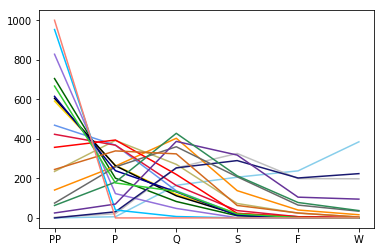

In [551]:
make_advancement_likelihood_table(womens_teams, womens_team_colors, womens_outcome_counts, division='Women\'s')

In [552]:
def reverse_cdf_plot_points_dist(teams, team_colors, outcome_counts, \
                                 mean_results_grouped_by_team, full_ymax_teams=[],\
                                 division='(INSERT DIVISION)'):
    """
    Plot CDF of points outcomes for each team 
    
    Returns nothing
    """ 
    xlim_left = -0.5
    xlim_right = 30
    fig = plt.figure(figsize=(9,8))
    fig.patch.set_facecolor('white')
    plt.plot([xlim_left, xlim_right], [1,1], '-', color='gray', linewidth=0.5)
    for i, team in enumerate(teams):
        #plt.subplot(5,4,4*np.mod(i,5)+1 + np.floor(i/5.))
        
        # Calculate and plot CDF
        x = outcome_counts['Points'][team].sort_index().index.values
        y = outcome_counts['Points'][team].sort_index().values/sum(outcome_counts['Points'][team].values)
        plt.plot(x, 1-y.cumsum(), '-', color=team_colors[team], label=team, linewidth=3)
        plt.xlim(right=xlim_right)
        plt.ylabel('Probability')
        plt.xlabel('Points')
        plt.title(f'How likely is each team\'s fantasy score to exceed x?\n({division} Division)')
    plt.plot([xlim_left, xlim_right], [1,1], '-', color='gray', linewidth=0.5)
    plt.xlim([xlim_left, xlim_right])
    plt.ylim([0, 1.0])
    plt.legend(loc='upper right', ncol=1)
    plt.tight_layout()
    plt.show()

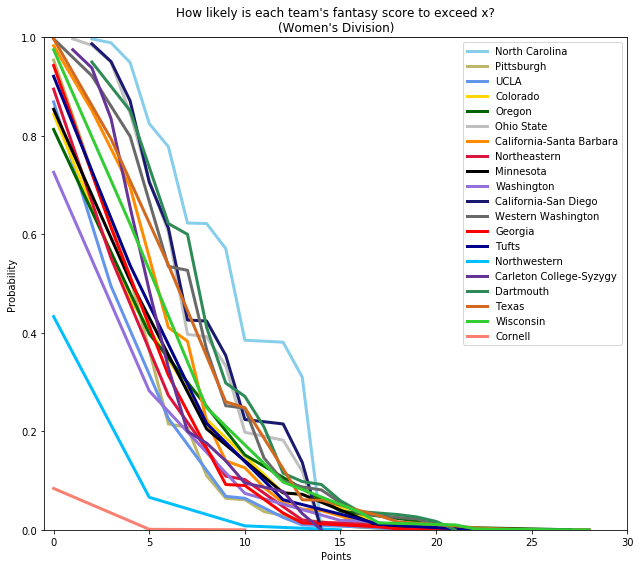

In [553]:
reverse_cdf_plot_points_dist(womens_teams, womens_team_colors, womens_outcome_counts, \
                             womens_mean_results_grouped_by_team, division='Women\'s')

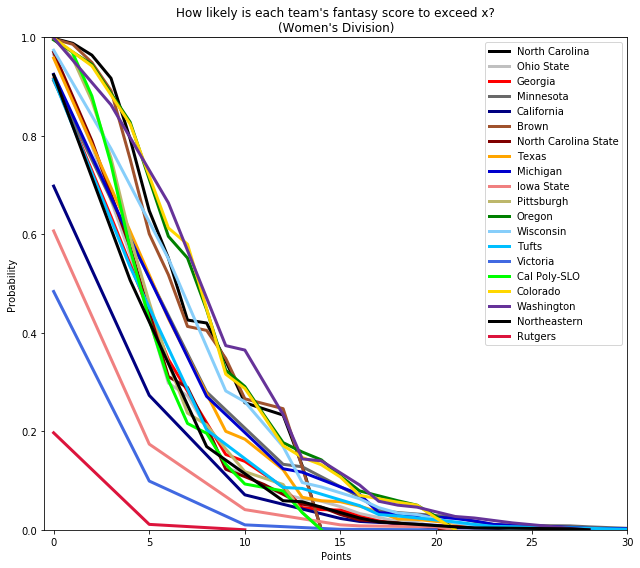

In [554]:
reverse_cdf_plot_points_dist(mens_teams, mens_team_colors, mens_outcome_counts, \
                             mens_mean_results_grouped_by_team, division='Women\'s')

In [555]:
# BIG QUESTION: What the expected high value overall of all teams of a given tournament?  
# i.e. What is the typical score needed to win?

mens_tournament_group_by_tournament_agg_max = mens_tournament_results.groupby('TournamentID').agg(max)

In [557]:
mens_tournament_group_by_tournament_agg_max

,TeamID,Pool,Rank,Seed,Team,PoolPlayPoints,PoolPlayWins,PoolPlayLosses,Wins,Losses,Points,MadeBracket,HighLevel
TournamentID,,,,,,,,,,,,,
0,19,D,5,5,Wisconsin,12.0,4.0,4.0,6.0,4.0,18.0,True,W
1,19,D,5,5,Wisconsin,12.0,4.0,4.0,7.0,4.0,16.0,True,W
2,19,D,5,5,Wisconsin,12.0,3.0,4.0,6.0,4.0,21.0,True,W
3,19,D,5,5,Wisconsin,12.0,4.0,4.0,6.0,4.0,16.0,True,W
4,19,D,5,5,Wisconsin,15.0,4.0,4.0,6.0,4.0,24.0,True,W
5,19,D,5,5,Wisconsin,9.0,4.0,4.0,7.0,4.0,20.0,True,W
6,19,D,5,5,Wisconsin,13.0,4.0,4.0,7.0,4.0,27.0,True,W
7,19,D,5,5,Wisconsin,13.0,4.0,4.0,6.0,4.0,18.0,True,W
8,19,D,5,5,Wisconsin,17.0,4.0,4.0,7.0,4.0,22.0,True,W


17.87


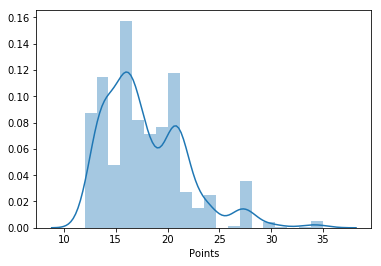

In [558]:
plt.figure()
sns.distplot(mens_tournament_group_by_tournament_agg_max['Points'])
print(np.mean(mens_tournament_group_by_tournament_agg_max['Points']))
plt.show()

In [559]:
def bar_plot_points_dist(teams, outcome_counts, mean_results_grouped_by_team, full_ymax_teams=[]):
    """
    Plot frequencies of each points outcome for each team as a bar graph.
    
    Returns nothing
    """ 
    fig = plt.figure(figsize=(10,10))
    fig.patch.set_facecolor('white')
    for i, team in enumerate(teams):
        plt.subplot(5,4,4*np.mod(i,5)+1 + np.floor(i/5.))
        plt.bar(outcome_counts['Points'][team].index.values, outcome_counts['Points'][team].values/sum(outcome_counts['Points'][team].values), width=1)
        if 4*np.mod(i,5)+1 + np.floor(i/5.) <= 12:
            plt.text(20., 0.2, 'mean:\n%0.2f' %mean_results_grouped_by_team[['Points']].loc[team])
        else:
            plt.text(20., 0.2, 'mean:\n%0.2f' %mean_results_grouped_by_team[['Points']].loc[team])
            plt.xlim(right=45)
        plt.xlim(left=-1, right=30)
        plt.ylim(top=0.5)
        if team in full_ymax_teams:
            plt.ylim(top=1.0)
        plt.ylabel('Frequency')
        plt.xlabel('Points')
        plt.title(team)
    plt.tight_layout()
    plt.show()

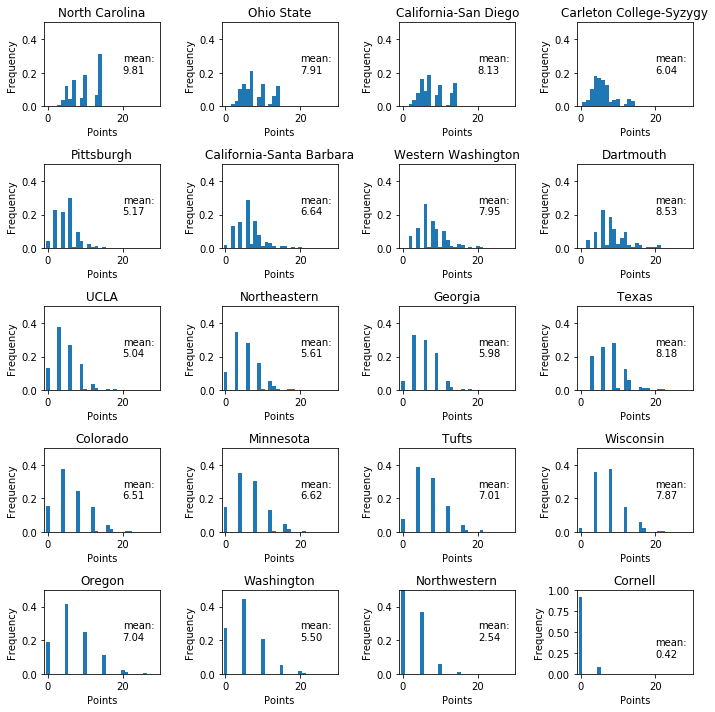

In [560]:
# Plot women's points distributions
bar_plot_points_dist(womens_teams, womens_outcome_counts, womens_mean_results_grouped_by_team, \
                     full_ymax_teams=['Cornell'])

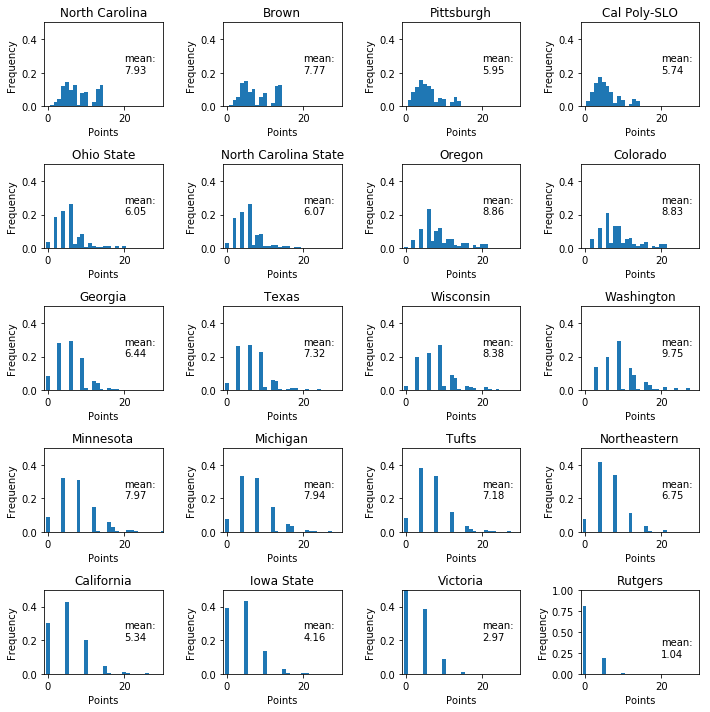

In [561]:
# Plot men's points distributions
bar_plot_points_dist(mens_teams, mens_outcome_counts, mens_mean_results_grouped_by_team, full_ymax_teams=['Rutgers'])

In [562]:
def bar_plot_poolplaywins_dist(teams, outcome_counts, mean_results_grouped_by_team, ymax=0.6):
    """
    Plot frequencies of each Wins outcome for each team.
    """
    fig = plt.figure(figsize=(10,10))
    fig.patch.set_facecolor('white')
    plt.rcParams.update({'font.size': 10})
    for i, team in enumerate(teams):
        plt.subplot(5,4,4*np.mod(i,5)+1 + np.floor(i/5.))
        color_val = 1#int(np.floor(i/5.))
        color_here = colors[color_val]
        plt.bar(outcome_counts['PoolPlayWins'][team].index.values, \
                outcome_counts['PoolPlayWins'][team].values/sum(outcome_counts['PoolPlayWins'][team].values), \
                width=0.95, color=color_here)
        if 4*np.mod(i,5)+1 + np.floor(i/5.) <= 12:
            plt.text(-0.5, 0.55*ymax, 'mean:\n%0.2f' %mean_results_grouped_by_team[['PoolPlayWins']].loc[team])
        else:
            plt.text(3., 0.55*ymax, 'mean:\n%0.2f' %mean_results_grouped_by_team[['PoolPlayWins']].loc[team])
        plt.xlim((-1, 5))
        plt.ylim(top=ymax)
        plt.xticks(range(5))
        plt.ylabel('Frequency')
        plt.xlabel('Pool Play Wins')
        plt.title(team)
    plt.tight_layout()
    plt.show()

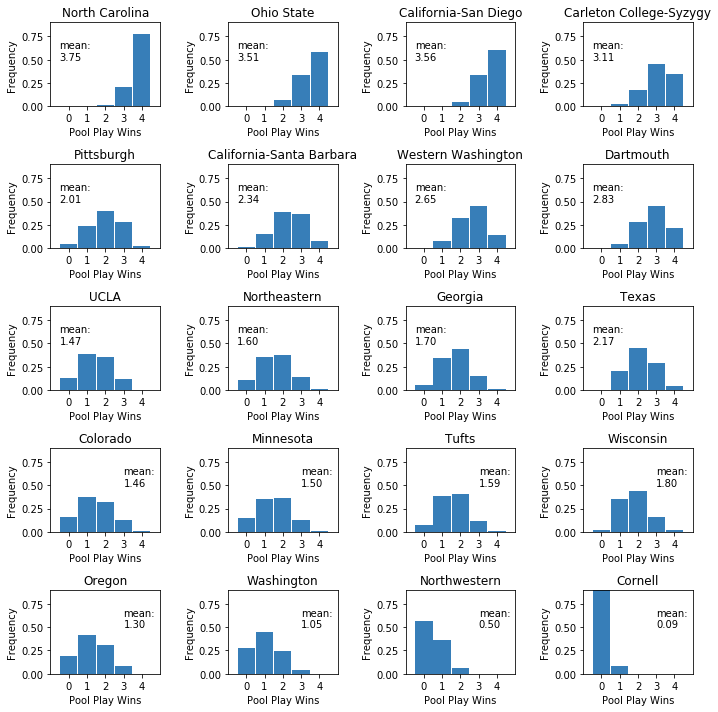

In [563]:
# Plot women's pool play wins distributions
bar_plot_poolplaywins_dist(womens_teams, womens_outcome_counts, womens_mean_results_grouped_by_team, ymax=0.9)

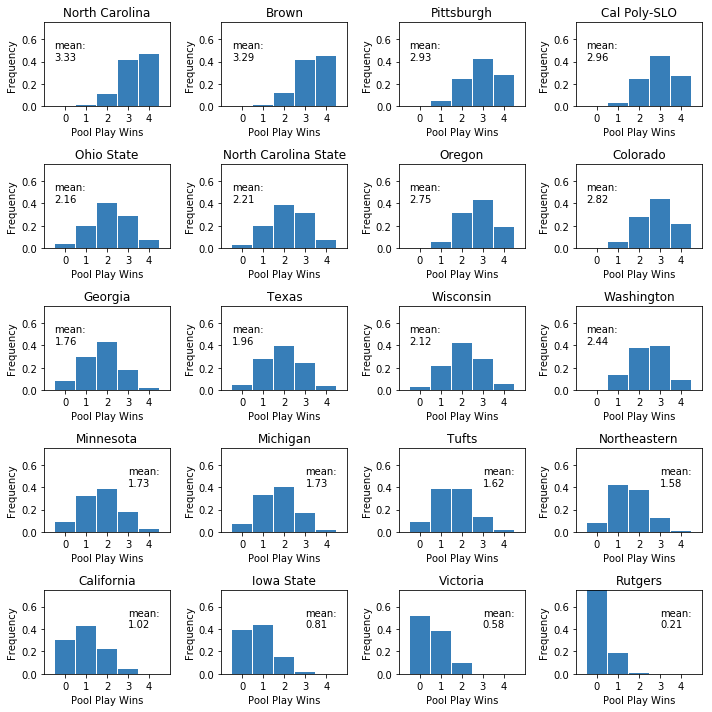

In [564]:
# Plot men's wins distributions
bar_plot_poolplaywins_dist(mens_teams, mens_outcome_counts, mens_mean_results_grouped_by_team, ymax=0.75)

In [565]:
def line_plot_poolplaywins_dist(teams, outcome_counts, team_ratings, team_colors, legend_font_size=10, division=''):
    """
    Plot frequencies of each Wins outcome for each team.
    """
    plt.figure(figsize=(11.5,8))
    for i, team in enumerate(teams):
        wins_here = outcome_counts['PoolPlayWins'][team].sort_index().index.values
        freq_here = outcome_counts['PoolPlayWins'][team].sort_index().loc[list(wins_here)]/sum(outcome_counts['PoolPlayWins'][team].values)
        label_here = team#'%s (%i)' %(team, team_ratings.loc[team]['Power Rating'])
        plt.plot(wins_here, freq_here[wins_here], label=label_here, color=team_colors[team], linewidth=3)
    plt.xlim([-0.2, 4.2])
    plt.ylim(bottom=0, top=1.0)
    plt.xticks(range(5))
    plt.ylabel('Frequency')
    plt.xlabel('Wins')
    plt.title('Pool Play Wins Distribution for %s Division' %division, fontsize=20)
    plt.rcParams.update({'font.size': 14})
    plt.legend(loc='upper center', ncol=4, fontsize=legend_font_size)
    plt.tight_layout()
    plt.show()

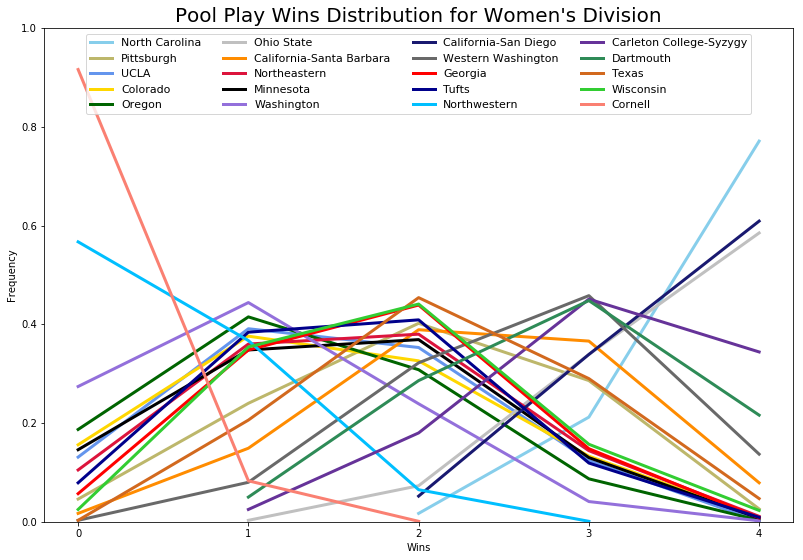

In [566]:
# Plot womens wins distributions
line_plot_poolplaywins_dist(womens_teams, womens_outcome_counts, womens_team_ratings, womens_team_colors,\
                    legend_font_size=11, division='Women\'s')

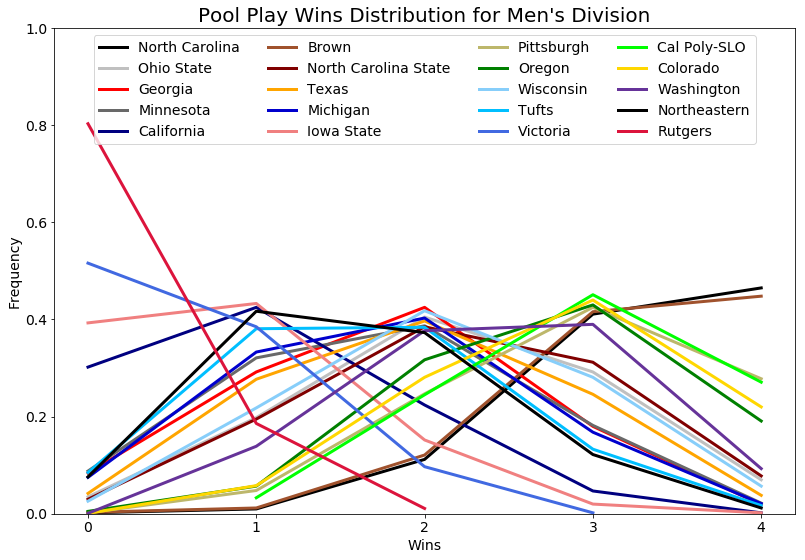

In [567]:
# Plot mens wins distributions
line_plot_poolplaywins_dist(mens_teams, mens_outcome_counts, mens_team_ratings, mens_team_colors,\
                    legend_font_size=14, division='Men\'s')